<br>
<p style="color:darkgreen; font-family:lato; font-size:300%; text-align:center;"> 
    FOREX
</p>

***

In [1]:
# General imports
import requests # Necessary to communicate with the webpage
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # necessary for using dates to plot
import seaborn as sns; sns.set()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Get today's date
today = datetime.date.today().strftime("%Y-%m-%d")

# Make a get request to get the latest daily exchange
response = requests.get("https://api.exchangeratesapi.io/history?start_at=2008-01-08&end_at="+today+"&symbols=EUR,USD,GBP,CAD&base=MXN") #HTTP/1.1
# Print the status code of the response.
if response.status_code==200:
    print('Yeah, that was a good request')
else:
    print('Oops, this is an incorrect command for request.get \nCheck for help about a status code with number')
    print(response.status_code)

#Shortcuts
figsize=(15,6)

Yeah, that was a good request


In [56]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = response.json()
data.keys()

dict_keys(['rates', 'start_at', 'base', 'end_at'])

In [3]:
# Create dataframe
df = pd.DataFrame(data['rates']).transpose()
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.asfreq('D')
# We need to fill the nans in order to make use of this series. These nans happen on the weekends!
df= df.fillna(method='ffill') 

# Since the MXN is way lower than any of the other currencies, this gives us something more intuitive than 
df = df.apply(lambda x: 1/x ) 

In [4]:
pd.set_option('display.max_rows', 10)

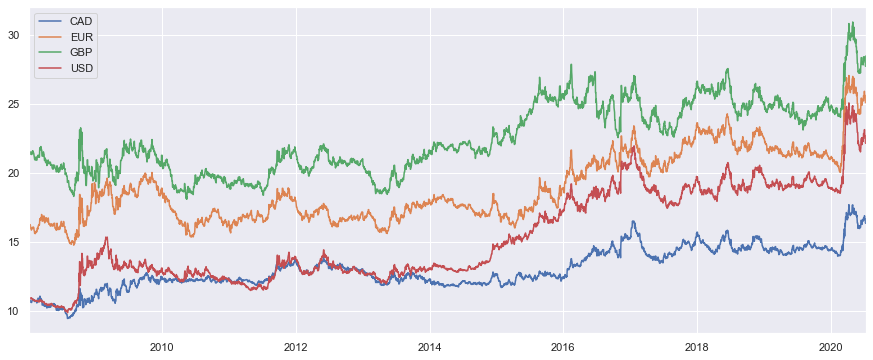

In [105]:
df.plot(figsize=figsize)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4566 entries, 2008-01-08 to 2020-07-08
Freq: D
Data columns (total 4 columns):
CAD    4566 non-null float64
EUR    4566 non-null float64
GBP    4566 non-null float64
USD    4566 non-null float64
dtypes: float64(4)
memory usage: 338.4 KB


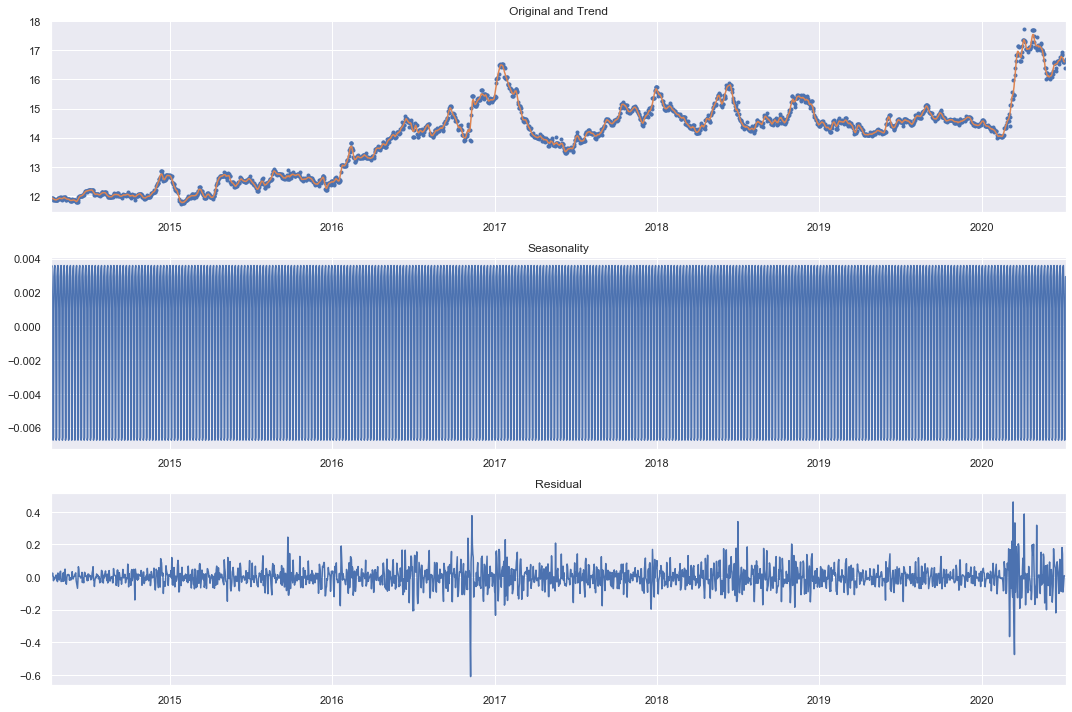

In [6]:
series = df.CAD
decomposed = seasonal_decompose(series.fillna(method='ffill'))
n=int(len(df)/2)
# n=365

# Plotting nicely the decomposition
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
series[-n:].plot(marker='.', linestyle='', label='Original');
decomposed.trend[-n:].plot(label='Trend');
plt.title('Original and Trend')

plt.subplot(3, 1, 2)
decomposed.seasonal[-n:].plot();
plt.title('Seasonality')

plt.subplot(3, 1, 3)
decomposed.resid[-n:].plot();
plt.title('Residual')
plt.tight_layout();

The 7-day seasonality is very clear and somewhat strong. We can also see that the trend is a good approximation of the data already

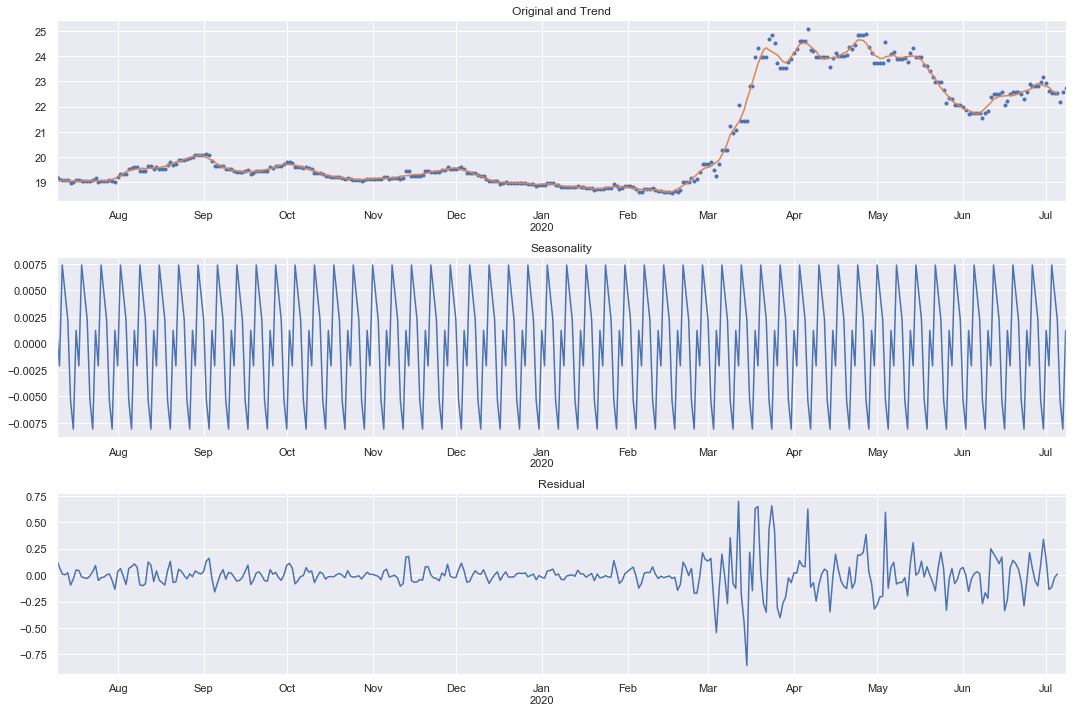

In [7]:
series = df.USD
decomposed = seasonal_decompose(series.fillna(method='ffill'))

n=365

# Plotting nicely the decomposition
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
series[-n:].plot(marker='.', linestyle='', label='Original');
decomposed.trend[-n:].plot(label='Trend');
plt.title('Original and Trend')

plt.subplot(3, 1, 2)
decomposed.seasonal[-n:].plot();
plt.title('Seasonality')

plt.subplot(3, 1, 3)
decomposed.resid[-n:].plot();
plt.title('Residual')
plt.tight_layout();

## White noise
Something we should always ask ourselves in order to know wether or not the decomposition is good is: Is the residual bit of the decomposition similar to white noise?
White noise is a sequence of random numbers which cannot be predicted. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model. 

We can tell if our time series is white noise by asking ourselves:
* Does the series has a zero mean?
* Is the variance constant over time?
* Is the correlation with its lags equal to 0?

count    4559.000000
mean        0.000025
std         0.092058
min        -1.046745
25%        -0.040012
50%        -0.002838
75%         0.038547
max         0.763908
Name: resid, dtype: float64

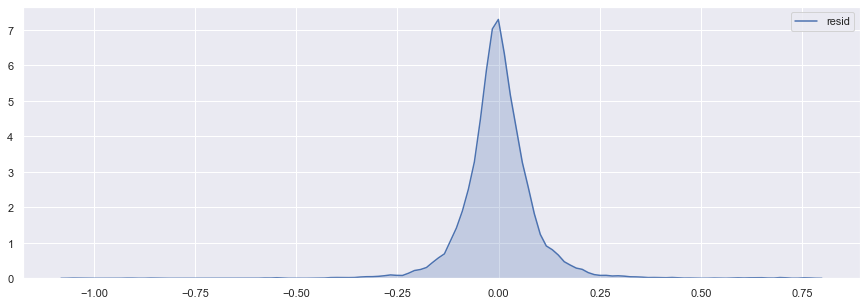

In [10]:
plt.figure(figsize=(15,5))
sns.kdeplot(decomposed.resid, shade=True);
decomposed.resid.describe()

As we can see, the decomposition is not bad at all. The mean is quite close to 0 and the standard deviation is rather low. Admittedly, the plot is a bit skewed but it's not terrible

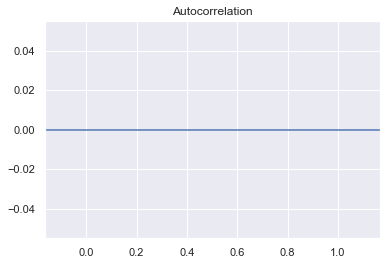

In [11]:
# pd.plotting.autocorrelation_plot(decomposed.resid);
plot_acf(decomposed.resid);

As expected, the autocorrelation plot tells us there is no significant correlation between the noise data and its lags. We conclude it is white noise.

In the future analysis, we will make use of different SARIMAX models but we now know that the decomposition we just made is a very decent benchmark

# SARIMAX 
We will first consider a single couple of currencies, say MXN and EUR.

## Determining orders


We can take a look at the ACF and PACF plots to have an estimate of what are the best $(p,q)$ orders might be:


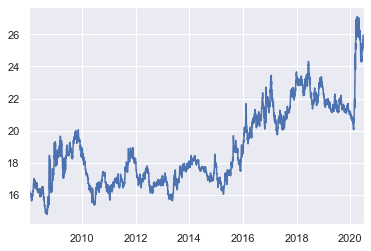

In [12]:
df.EUR.plot();

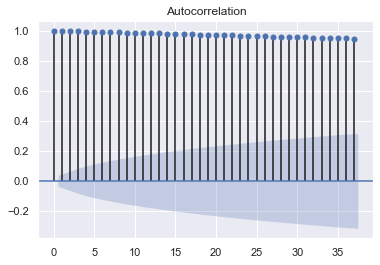

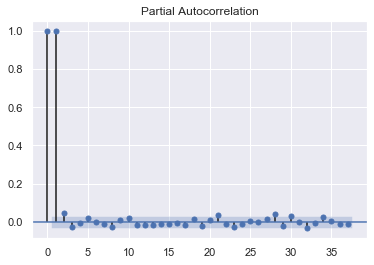

In [13]:
plot_acf(df.USD.fillna(method='ffill'),  alpha=.01);
plot_pacf(df.USD.fillna(method='ffill'));

Notice that the correlation between the data and its lags on the ACF plot tells us that there is an important correlation. However, the correlation between the data and lags>1 seems to be explained as a correlation-dragging effect from the first lag, as it is confirmed by looking at the PACF with a sharp cutoff. 

As you can see in [this explanation](https://people.duke.edu/~rnau/411arim3.htm) by people from Duke University, the ACF decreasing slowly and having a sharp cutoff at some lag $n$ is signal of considering an $\text{AR}(n)$ model.

However, in reality, the best thing to do is to run several models and check which one performs very without being too complex. We measure this with the Akaike Information Criterion or **AIC**. In general we want to minimise this "measure" to have a good performance without having too many parameters that would make a really complex model.

In [14]:
%%time
auto_arima(df.USD.fillna(method='ffill'), seasonal=True, m=7, 
           start_p=0, start_q=0, max_p=3, max_q=3, max_P=3, max_Q=3,
           trace=True, information_criterion='aic', scoring='mse').summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=-6175.858, BIC=-6150.154, Time=5.941 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=-6156.497, BIC=-6143.645, Time=0.868 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=-6160.548, BIC=-6134.844, Time=2.116 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=-6160.271, BIC=-6134.567, Time=1.797 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=-6156.524, BIC=-6150.098, Time=0.253 seconds
Fit ARIMA(0,1,0)x(0,0,1,7) [intercept=True]; AIC=-6156.016, BIC=-6136.738, Time=1.045 seconds
Fit ARIMA(0,1,0)x(1,0,0,7) [intercept=True]; AIC=-6156.140, BIC=-6136.862, Time=0.973 seconds
Fit ARIMA(0,1,0)x(2,0,1,7) [intercept=True]; AIC=-6177.033, BIC=-6144.903, Time=12.893 seconds
Fit ARIMA(0,1,0)x(2,0,0,7) [intercept=True]; AIC=-6161.863, BIC=-6136.159, Time=2.971 seconds
Fit ARIMA(0,1,0)x(3,0,1,7) [intercept=True]; AIC=-6157.965, BIC=-6119.409, Time=9.753 seconds
Fit ARIMA(0,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 4565
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood                3096.244
Date:                                Tue, 07 Jul 2020   AIC                          -6180.488
Time:                                        18:13:17   BIC                          -6141.932
Sample:                                             0   HQIC                         -6166.912
                                               - 4565                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.003      0.316      -0.000       0.001
ar.L1         -0.0345      0.006     -5.327      0.000      -0.047      -0.022
ar.S.L7        0.8391      0.039     21.375      0.000       0.762       0.916
ma.S.L7       -0.8264      0.039    -21.148      0.000      -0.903      -0.750
ma.S.L14       0.0295      0.008      3.600      0.000       0.013       0.046
sigma2         0.0151      0.000    149.881      0.000       0.015       0.015
===================================================================================
Ljung-Box (Q):                       87.05   Jarque-Bera (JB):             79226.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**SARIMAX(1, 1, 0)x(1, 0, 2, 7)** seems to be the best

## Train-test split

In Time series we cannot really make use of the usual methods to split the dataset into a training and a testing set (where one might randomly take samples from the original set or do some sort of cross-validation). 
Here we can only split the data by choosing a point in time and take the previous data as training, compare the predictions with the test set. 


In [8]:
test_size = 14 # Forecast length
X_train, X_test = df.EUR[:-test_size].fillna(method='ffill'), df.EUR[-test_size:].fillna(method='ffill')

print('Observations:            %d' % (len(df.EUR)))
print('Training Observations:   %d' % (len(X_train)))
print('Testing Observations:    %d' % (len(X_test)))
print('\nLast date:               {}'.format(X_test.index[-1].strftime('%d %B %Y')))

Observations:            4566
Training Observations:   4552
Testing Observations:    14

Last date:               08 July 2020


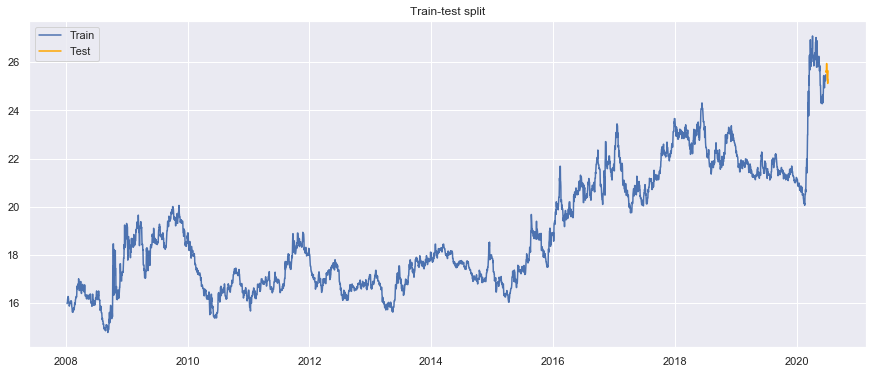

In [9]:
plt.figure(figsize=figsize)
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test', color='orange')
plt.title('Train-test split')
plt.legend();

Now fit the model that we saw would be the most convenient.

In [10]:
model = SARIMAX(X_train, order=(1,1,0), seasonal_order=(1,0,2,7), enforce_invertibility=False )
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    EUR   No. Observations:                 4552
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood                2214.297
Date:                                Wed, 08 Jul 2020   AIC                          -4418.593
Time:                                        19:40:03   BIC                          -4386.478
Sample:                                    01-08-2008   HQIC                         -4407.284
                                         - 06-24-2020                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0348      0.006     -5.905      0.000      -0.046      -0.023
ar.S.L7       -0.6316      0.134     -4.719      0.000      -0.894      -0.369
ma.S.L7        0.6752      0.135      4.998      0.000       0.410       0.940
ma.S.L14       0.0605      0.008      7.948      0.000       0.046       0.075
sigma2         0.0221      0.000    150.202      0.000       0.022       0.022
===================================================================================
Ljung-Box (Q):                       58.79   Jarque-Bera (JB):             82756.26
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.15
Prob(H) (two-sided):                  0.04   Kurtosis:                        23.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now obtain predictions 

In [11]:
start = len(X_train)
end = len(X_train)+len(X_test)-1 # There's a need of getting -1 because the following funciton comprehends the last item
pred = fitted_model.predict( start=start, end=end, dynamic=False).rename('SARIMAX(0,1,1)x(2,0,0,7) Prediction')

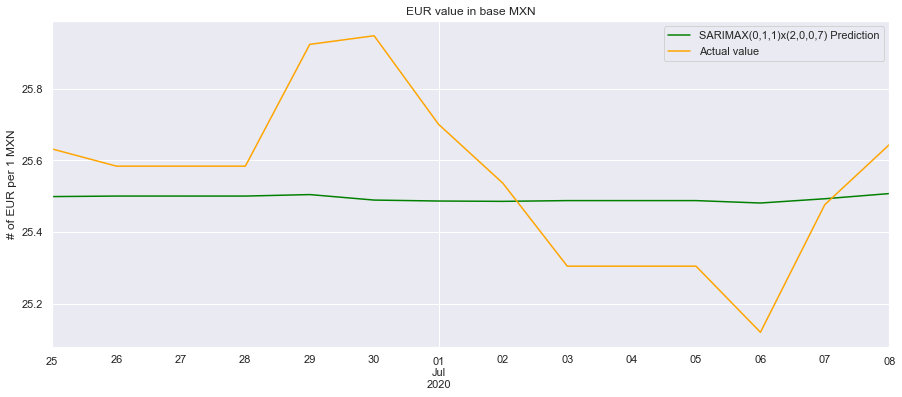

In [12]:
# Plot predictions against known values
ax = pred.plot(legend=True, color='green')
X_test.plot(legend=True,figsize=figsize, title='EUR value in base MXN', label='Actual value', color='orange')

ax.autoscale(axis='x',tight=True)
ax.set(xlabel='', ylabel='# of EUR per 1 MXN' );

Let's plot it with the training set as well and zoom in to the last 3 months (last n=90 days)  to be able to see something in this plot

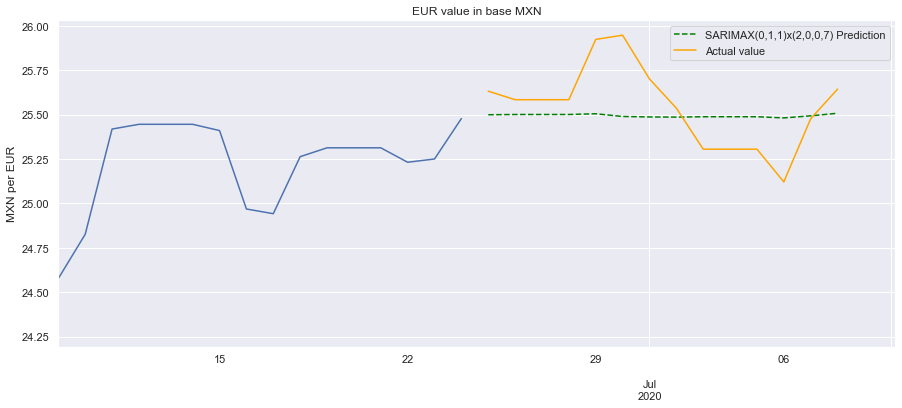

In [13]:
# Plot predictions against known values
n=30

X_train[-n:].plot(label='Train')
pred.plot(legend=True, color='green', linestyle='--')
ax = X_test.plot(legend=True,figsize=figsize, title='EUR value in base MXN', label='Actual value', color='orange')

# ax.autoscale(axis='x',tight=True)
ax.autoscale(axis='both',tight=False)
plt.xlim(df.index[-n])#, df.index[-1])
ax.set(xlabel='', ylabel='MXN per EUR' );

The prediction looks quite good apparently. Let's quantify it though

## Evaluate the model

We now calculate the RMSE error of this predicion and compare it to the mean value of the data, to see how good was our prediction 


In [14]:
from statsmodels.tools.eval_measures import mse,rmse

error= rmse(X_test, pred)
print(f'SARIMA(0,0,0)(1,0,1,7) RMSE Error:   {error:11.10}')
print(f'The mean value of the test set is    {X_test.mean():11.10}')
print(f'\nThis means that the error percentage is {100*error/X_test.mean():.4f}%')

SARIMA(0,0,0)(1,0,1,7) RMSE Error:   0.2268382004
The mean value of the test set is    25.54599285

This means that the error percentage is 0.8880%


# Walk-forward validation method

This way of evaluating takes the training data and predicts one step forward, then the actual value at that time is added to the training set. We continue doing this until the test dataset is exhausted.
 In this evaluation method, the baseline is the Persistence model, which says things won't change at all from one day to the next one.
 

## Persistence model

In [89]:
persistence_pred = df.EUR.shift(1)[-test_size:]

In [90]:
pers_error= rmse(X_test, persistence_pred)
print(f'Persistence model RMSE Error:       {pers_error:11.10}')
print(f'The mean value of the test set is   {X_test.mean():11.10}')
print(f'\nThis means that the error percentage is {100*pers_error/X_test.mean():.4f}%')

Persistence model RMSE Error:       0.1834934556
The mean value of the test set is   25.54599285

This means that the error percentage is 0.7183%


## SARIMAX

In [74]:
pred_SARIMAX[0]

25.49882947085837

In [92]:
%%time
start = len(X_train)
pred_SARIMAX = []
for k in range(len(X_test)):
    # We'll use the model suggested by pmdarima 
    model = SARIMAX( pd.concat([X_train,X_test[:k]]) , order=(1,1,0), seasonal_order=(1,0,2,7), enforce_invertibility=False )
    # Fit
    fitted_model = model.fit()
    # Predict and append to pred_SARIMAX
    end = start + k# There's a need of getting -1 because the following funciton comprehends the last item
    pred_SARIMAX.append( fitted_model.predict( start=start, end=end, dynamic=False).values[k] )

Wall time: 1min 7s


## Models comparison
After the predictions of these models, we can plot the predictions and compare their errors to see their performance

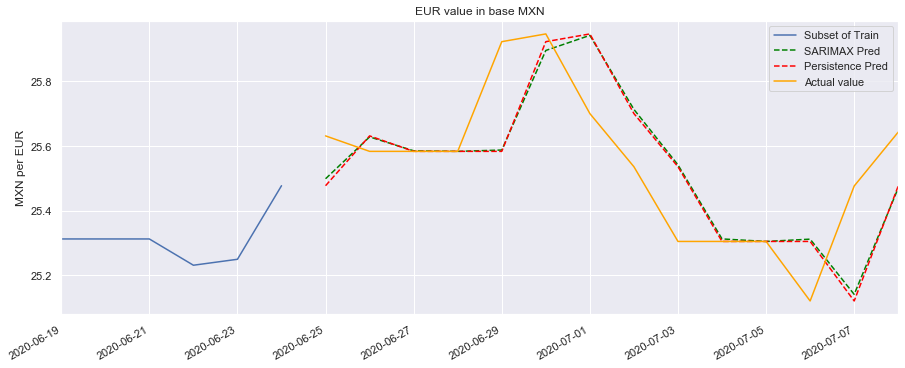

In [94]:
# Plot predictions of models and a bit of the training set 
n=20 # Number of days to be plotted

plt.plot(X_train.index[-n+len(X_test):], X_train[-n+len(X_test):], label='Subset of Train')
plt.plot(X_test.index, pred_SARIMAX, linestyle='--', color='green', label='SARIMAX Pred')
plt.plot(X_test.index, persistence_pred, linestyle='--', color='red', label='Persistence Pred')
ax = X_test.plot(legend=True,figsize=figsize, title='EUR value in base MXN', label='Actual value', color='orange')

# Plot configuration
ax.autoscale(axis='x',tight=True)
# ax.autoscale(axis='both',tight=False)
plt.xlim(df.index[-n])#, df.index[-1])
ax.set(xlabel='', ylabel='MXN per EUR' );
ax.legend();

In [96]:
df_pred_SARIMAX = pd.Series(data=pred_SARIMAX, index=X_test.index)
df_pred_SARIMAX.index.freq = 'D'

SARIMAX_error= rmse(X_test, pred_SARIMAX )
print(f'The mean value of the test set is   {X_test.mean():11.10}\n')

print(f'SARIMAX RMSE:                    {SARIMAX_error:11.10}')
print(f'SARIMAX error percentage:        {100*SARIMAX_error/X_test.mean():.4f}%\n')

print(f'Persistence RMSE:                {pers_error:11.10}')
print(f'Persistence error percentage:    {100*pers_error/X_test.mean():.4f}%')

The mean value of the test set is   25.54599285

SARIMAX RMSE:                    0.181228871
SARIMAX error percentage:        0.7094%

Persistence RMSE:                0.1834934556
Persistence error percentage:    0.7183%


As we can see, the **SARIMAX(1,1,0)x(1,0,2,7)** model behaves only slightly better than the persistence model.

# Facebook Prophet

In [99]:
from fbprophet import Prophet

# Prophet gets mad if the dataframe is not exactly like it wants it to be
dfprophet = pd.DataFrame({'ds':df.index, 'y':df.EUR.values})

prophet = Prophet()
prophet.fit(dfprophet[-test_size*10:])
future = prophet.make_future_dataframe(periods=test_size,freq='d')
forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


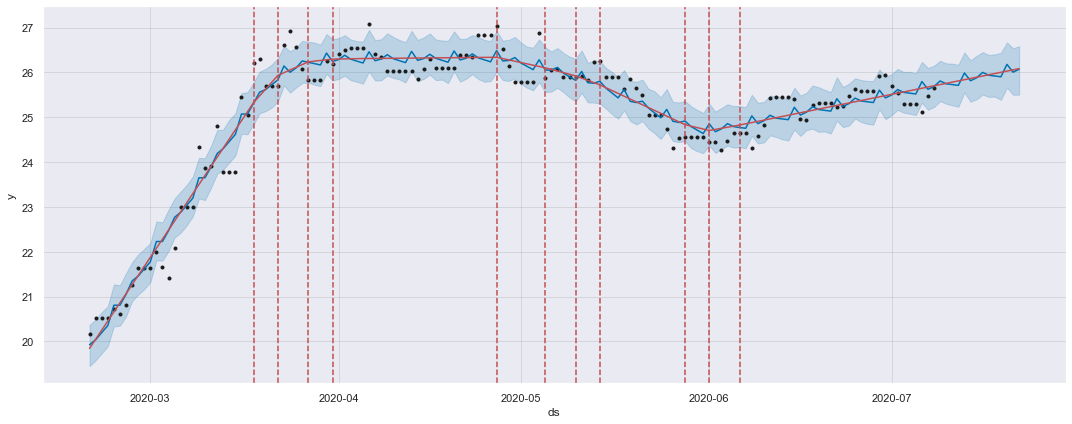

In [101]:
from fbprophet.plot import add_changepoints_to_plot

pd.plotting.register_matplotlib_converters() # Necessary for matplotlib to understand plot this
fig = prophet.plot(forecast, figsize=figsize)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
# plt.xlim(df.index[-n])#, df.index[-1])


Yeah, this seems quite bad actually...
Let's check the RMSE error like we did before

In [ ]:
error_prophet= rmse(forecast.yhat[-test_size:], X_test)
print(f'Prophet RMSE Error:                  {error_prophet:11.10}')
print(f'The mean value of the test set is    {X_test.mean():11.10}')
print(f'\nThis means that the error percentage is {100*error_prophet/X_test.mean():.4f}%')

# Granger causality
One question we may ask is: Is there a [Granger causality between](https://en.wikipedia.org/wiki/Granger_causality) the behaviour of the value of the EUR, USD and GBP with respect to the MXN? This question is tantamount to ask how strong is the MXN globally, so we do expect these time series to be **precedent** of one another. 
If they were not, there would be many ways to make several transactions in a loop that would produce a net income.

**NB:** If the **p-value** is smaller than .05, we reject the null hypothesis, which means one series is Granger-caused by the other. If $p>.05$, we cannot reject the hypothesis and we say the series are not Granger-caused

In [25]:
# %%time 
from statsmodels.tsa.stattools import grangercausalitytests
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df[['EUR','USD']], maxlag=60);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0085  , p=0.0081  , df_denom=4561, df_num=1
ssr based chi2 test:   chi2=7.0131  , p=0.0081  , df=1
likelihood ratio test: chi2=7.0077  , p=0.0081  , df=1
parameter F test:         F=7.0085  , p=0.0081  , df_denom=4561, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0541  , p=0.0024  , df_denom=4558, df_num=2
ssr based chi2 test:   chi2=12.1214 , p=0.0023  , df=2
likelihood ratio test: chi2=12.1053 , p=0.0024  , df=2
parameter F test:         F=6.0541  , p=0.0024  , df_denom=4558, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9809  , p=0.0076  , df_denom=4555, df_num=3
ssr based chi2 test:   chi2=11.9611 , p=0.0075  , df=3
likelihood ratio test: chi2=11.9455 , p=0.0076  , df=3
parameter F test:         F=3.9809  , p=0.0076  , df_denom=4555, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0471  , p=0.

ssr based F test:         F=1.5707  , p=0.0285  , df_denom=4480, df_num=28
ssr based chi2 test:   chi2=44.5394 , p=0.0246  , df=28
likelihood ratio test: chi2=44.3222 , p=0.0258  , df=28
parameter F test:         F=1.5707  , p=0.0285  , df_denom=4480, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=1.5391  , p=0.0325  , df_denom=4477, df_num=29
ssr based chi2 test:   chi2=45.2230 , p=0.0280  , df=29
likelihood ratio test: chi2=44.9990 , p=0.0294  , df=29
parameter F test:         F=1.5391  , p=0.0325  , df_denom=4477, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=1.4934  , p=0.0410  , df_denom=4474, df_num=30
ssr based chi2 test:   chi2=45.4128 , p=0.0353  , df=30
likelihood ratio test: chi2=45.1869 , p=0.0371  , df=30
parameter F test:         F=1.4934  , p=0.0410  , df_denom=4474, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=1.4724  , p=0.0444  , df_denom=4471, df_num=3

ssr based F test:         F=1.2081  , p=0.1406  , df_denom=4399, df_num=55
ssr based chi2 test:   chi2=68.1225 , p=0.1101  , df=55
likelihood ratio test: chi2=67.6132 , p=0.1182  , df=55
parameter F test:         F=1.2081  , p=0.1406  , df_denom=4399, df_num=55

Granger Causality
number of lags (no zero) 56
ssr based F test:         F=1.1956  , p=0.1520  , df_denom=4396, df_num=56
ssr based chi2 test:   chi2=68.6720 , p=0.1191  , df=56
likelihood ratio test: chi2=68.1543 , p=0.1279  , df=56
parameter F test:         F=1.1956  , p=0.1520  , df_denom=4396, df_num=56

Granger Causality
number of lags (no zero) 57
ssr based F test:         F=1.2139  , p=0.1310  , df_denom=4393, df_num=57
ssr based chi2 test:   chi2=71.0051 , p=0.1005  , df=57
likelihood ratio test: chi2=70.4517 , p=0.1086  , df=57
parameter F test:         F=1.2139  , p=0.1310  , df_denom=4393, df_num=57

Granger Causality
number of lags (no zero) 58
ssr based F test:         F=1.1975  , p=0.1462  , df_denom=4390, df_num=5

Apparently these series are heavily Granger causal amongst each other until lag=40.